/Library/TeX/texbin/latex


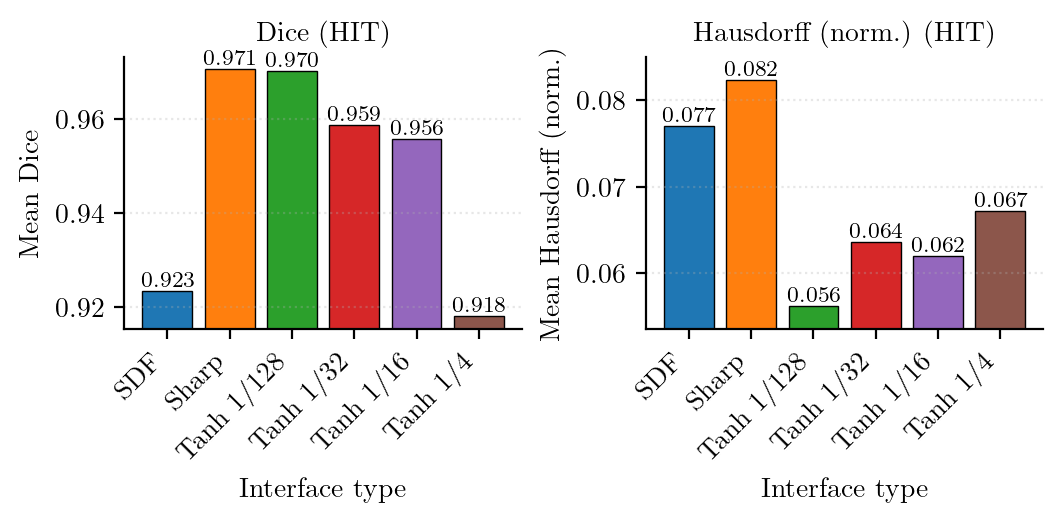

In [8]:
import shutil;

print(shutil.which("latex"))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction

from src.interface_representation.interface_types import InterfaceType

# Use LaTeX for all text
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'Times'],
    'axes.unicode_minus': False
})


def float_to_fraction(float_num):
    fraction = Fraction(float_num).limit_denominator()
    return f"{fraction.numerator}/{fraction.denominator}"


def label_from_row(row):
    interface_type = row.get('interface_type', None)
    epsilon = row.get('epsilon', None)
    if interface_type == InterfaceType.TANH_EPSILON.name:
        # Fallback to 'Tanh' if epsilon is missing
        if epsilon is not None and not pd.isna(epsilon):
            return f"Tanh {float_to_fraction(epsilon)}"
        else:
            return 'Tanh'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT.name:
        return 'SDF'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE.name:
        return 'SDF approx'
    elif interface_type == InterfaceType.HEAVISIDE.name:
        return 'Sharp'
    else:
        return 'Unknown'


def preferred_label_order(labels):
    """
    Order labels as: SDF, SDF approx, Sharp, then Tanh (ascending epsilon), then others.
    """
    labels = list(labels)
    ordered = []
    for core in ['SDF', 'SDF approx', 'Sharp']:
        if core in labels:
            ordered.append(core)
    # Tanh labels
    tanh_labels = [l for l in labels if isinstance(l, str) and l.startswith('Tanh') and l not in ordered]

    def tanh_key(lab):
        try:
            parts = lab.split()
            if len(parts) == 2:
                num, den = parts[1].split('/')
                return float(int(num) / int(den))
            else:
                return float('inf')
        except Exception:
            return float('inf')

    tanh_sorted = sorted(tanh_labels, key=tanh_key)
    ordered.extend(tanh_sorted)
    # Remaining others
    others = [l for l in labels if l not in ordered]
    ordered.extend(others)
    return ordered


def plot_bars_for_dataset_side_by_side(
        df,
        dataset_value='HIT',
        dataset_col='dataset',
        drop_tanh_fractions={'1/64', '1/8'},
        hausdorff_normalise=True,
        savepath='metrics_bars_HIT.pdf',
        dpi=200
):
    """
    Create two side-by-side bar plots (Dice and Hausdorff normalized) for a single dataset (e.g., 'HIT'),
    comparing all interface types. No 'mu' column is required.
    If 'dataset' column is absent, use all rows.
    """
    # If dataset column exists, filter; otherwise use full dataframe
    if dataset_col is not None and dataset_col in df.columns:
        df_ds = df[df[dataset_col] == dataset_value].copy()
        if df_ds.empty:
            raise ValueError(f"No rows found for dataset '{dataset_value}' in column '{dataset_col}'.")
    else:
        df_ds = df.copy()

    # Build labels
    df_ds['label'] = df_ds.apply(label_from_row, axis=1)

    # Normalise Hausdorff if requested
    if hausdorff_normalise and 'hausdorff' in df_ds.columns:
        df_ds['hausdorff'] = df_ds['hausdorff'] / 64.0

    # Drop rows with missing metric values
    dice_work = df_ds[df_ds['dice'].notna()] if 'dice' in df_ds.columns else pd.DataFrame()
    haus_work = df_ds[df_ds['hausdorff'].notna()] if 'hausdorff' in df_ds.columns else pd.DataFrame()

    if dice_work.empty and haus_work.empty:
        raise ValueError("No valid Dice or Hausdorff data found after filtering.")

    # Compute mean per label
    dice_series = dice_work.groupby('label')['dice'].mean() if not dice_work.empty else pd.Series(dtype=float)
    haus_series = haus_work.groupby('label')['hausdorff'].mean() if not haus_work.empty else pd.Series(dtype=float)

    # Drop specific Tanh epsilon labels
    def _drop_tanh(series):
        to_keep = []
        for lab in series.index:
            if isinstance(lab, str) and lab.startswith('Tanh'):
                parts = lab.split()
                if len(parts) == 2:
                    frac = parts[1]
                    if frac in drop_tanh_fractions:
                        continue
            to_keep.append(lab)
        return series.loc[to_keep]

    dice_series = _drop_tanh(dice_series)
    haus_series = _drop_tanh(haus_series)

    # Determine and order labels consistently across both metrics
    all_labels = list(dict.fromkeys(list(dice_series.index) + list(haus_series.index)))
    labels = preferred_label_order(all_labels)

    # Color mapping for labels (consistent across plots)
    cmap = plt.get_cmap('tab10')
    colors = {lab: cmap(i % 10) for i, lab in enumerate(labels)}

    fig, axs = plt.subplots(
        1, 2,
        figsize=(2.6 * 2, 2.5),
        constrained_layout=True,
        dpi=dpi
    )

    def _despine(ax):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    def _plot_metric(ax, series, metric_name, ylabel=None, is_dice=False):
        if series.empty:
            ax.text(0.5, 0.5, r'No data', ha='center', va='center', fontsize=9, transform=ax.transAxes)
            ax.set_xticks([])
            if ylabel:
                ax.set_ylabel(ylabel)
            ax.set_title(rf"{metric_name} ({dataset_value})", fontsize=10)
            ax.grid(axis='y', linestyle=':', alpha=0.3)
            _despine(ax)
            return

        s = series.reindex(labels).dropna()
        labs = list(s.index)
        vals = s.values
        x = np.arange(len(labs))
        bar_colors = [colors[lab] for lab in labs]
        ax.bar(x, vals, color=bar_colors, edgecolor='black', linewidth=0.5)
        ax.set_xticks(x)
        ax.set_xticklabels(labs, rotation=45, ha='right')
        if ylabel:
            ax.set_ylabel(ylabel)
        ax.set_title(rf"{metric_name} ({dataset_value})", fontsize=10)
        ax.grid(axis='y', linestyle=':', alpha=0.3)

        # Per-plot y-limits
        ymin, ymax = float(np.min(vals)), float(np.max(vals))
        if is_dice:
            ymin = max(0.0, ymin)
            ymax = min(1.0, ymax)
            pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
            ax.set_ylim(max(0.0, ymin - pad), min(1.0, ymax + pad))
        else:
            pad = 0.1 * (ymax - ymin if ymax > ymin else 1.0)
            ax.set_ylim(max(0.0, ymin - pad), ymax + pad)

        # Numeric labels above bars
        for xi, yi in zip(x, vals):
            ax.text(xi, yi, f"{yi:.3f}", ha='center', va='bottom', fontsize=8)

        _despine(ax)
        ax.set_xlabel(r"Interface type")

    # Plot Dice (left) and Hausdorff (right)
    _plot_metric(
        axs[0],
        dice_series,
        "Dice",
        ylabel="Mean Dice",
        is_dice=True
    )

    haus_title = "Hausdorff (norm.)" if hausdorff_normalise else "Hausdorff"
    _plot_metric(
        axs[1],
        haus_series,
        haus_title,
        ylabel=f"Mean {haus_title}",
        is_dice=False
    )

    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    return fig, axs


# Load data and plot for HIT dataset (uses entire CSV if 'dataset' column is missing)
df = pd.read_csv('evaluation_results_v34.csv')
plot_bars_for_dataset_side_by_side(df, dataset_value='HIT', savepath='metrics_bars_HIT.pdf')
plt.show()

/Library/TeX/texbin/latex


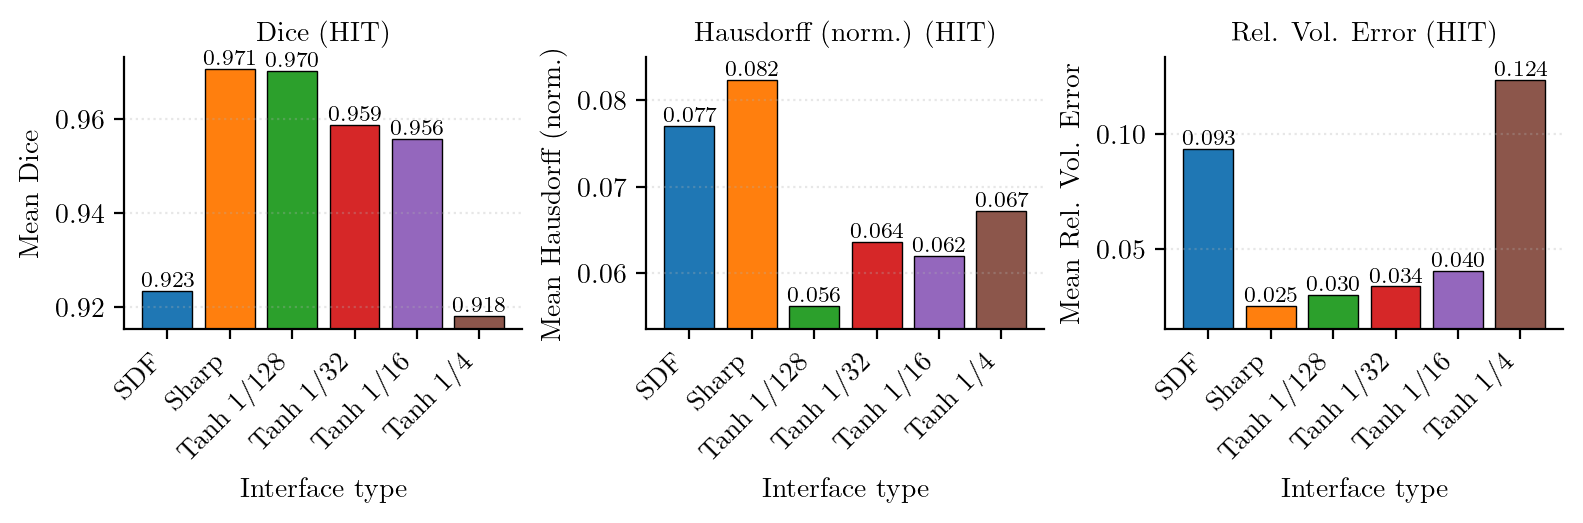

In [10]:
import shutil;

print(shutil.which("latex"))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction

from src.interface_representation.interface_types import InterfaceType

# Use LaTeX for all text
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'Times'],
    'axes.unicode_minus': False
})


def float_to_fraction(float_num):
    fraction = Fraction(float_num).limit_denominator()
    return f"{fraction.numerator}/{fraction.denominator}"


def label_from_row(row):
    interface_type = row.get('interface_type', None)
    epsilon = row.get('epsilon', None)
    if interface_type == InterfaceType.TANH_EPSILON.name:
        # Fallback to 'Tanh' if epsilon is missing
        if epsilon is not None and not pd.isna(epsilon):
            return f"Tanh {float_to_fraction(epsilon)}"
        else:
            return 'Tanh'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT.name:
        return 'SDF'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE.name:
        return 'SDF approx'
    elif interface_type == InterfaceType.HEAVISIDE.name:
        return 'Sharp'
    else:
        return 'Unknown'


def preferred_label_order(labels):
    """
    Order labels as: SDF, SDF approx, Sharp, then Tanh (ascending epsilon), then others.
    """
    labels = list(labels)
    ordered = []
    for core in ['SDF', 'SDF approx', 'Sharp']:
        if core in labels:
            ordered.append(core)
    # Tanh labels
    tanh_labels = [l for l in labels if isinstance(l, str) and l.startswith('Tanh') and l not in ordered]

    def tanh_key(lab):
        try:
            parts = lab.split()
            if len(parts) == 2:
                num, den = parts[1].split('/')
                return float(int(num) / int(den))
            else:
                return float('inf')
        except Exception:
            return float('inf')

    tanh_sorted = sorted(tanh_labels, key=tanh_key)
    ordered.extend(tanh_sorted)
    # Remaining others
    others = [l for l in labels if l not in ordered]
    ordered.extend(others)
    return ordered


def plot_bars_for_dataset_side_by_side(
        df,
        dataset_value='HIT',
        dataset_col='dataset',
        drop_tanh_fractions={'1/64', '1/8'},
        hausdorff_normalise=True,
        savepath='metrics_bars_HIT.pdf',
        dpi=200
):
    """
    Create three side-by-side bar plots (Dice, Hausdorff normalized, Relative Volume Error)
    for a single dataset (e.g., 'HIT'), comparing all interface types. No 'mu' column is required.
    If 'dataset' column is absent, use all rows.
    """
    # If dataset column exists, filter; otherwise use full dataframe
    if dataset_col is not None and dataset_col in df.columns:
        df_ds = df[df[dataset_col] == dataset_value].copy()
        if df_ds.empty:
            raise ValueError(f"No rows found for dataset '{dataset_value}' in column '{dataset_col}'.")
    else:
        df_ds = df.copy()

    # Build labels
    df_ds['label'] = df_ds.apply(label_from_row, axis=1)

    # Normalise Hausdorff if requested
    if hausdorff_normalise and 'hausdorff' in df_ds.columns:
        df_ds['hausdorff'] = df_ds['hausdorff'] / 64.0

    # Drop rows with missing metric values
    dice_work = df_ds[df_ds['dice'].notna()] if 'dice' in df_ds.columns else pd.DataFrame()
    haus_work = df_ds[df_ds['hausdorff'].notna()] if 'hausdorff' in df_ds.columns else pd.DataFrame()
    rel_work = df_ds[df_ds['rel_vol_error'].notna()] if 'rel_vol_error' in df_ds.columns else pd.DataFrame()

    if dice_work.empty and haus_work.empty and rel_work.empty:
        raise ValueError("No valid Dice, Hausdorff, or Rel. Vol. Error data found after filtering.")

    # Compute mean per label
    dice_series = dice_work.groupby('label')['dice'].mean() if not dice_work.empty else pd.Series(dtype=float)
    haus_series = haus_work.groupby('label')['hausdorff'].mean() if not haus_work.empty else pd.Series(dtype=float)
    rel_series = rel_work.groupby('label')['rel_vol_error'].mean() if not rel_work.empty else pd.Series(dtype=float)

    # Drop specific Tanh epsilon labels
    def _drop_tanh(series):
        to_keep = []
        for lab in series.index:
            if isinstance(lab, str) and lab.startswith('Tanh'):
                parts = lab.split()
                if len(parts) == 2:
                    frac = parts[1]
                    if frac in drop_tanh_fractions:
                        continue
            to_keep.append(lab)
        return series.loc[to_keep]

    dice_series = _drop_tanh(dice_series)
    haus_series = _drop_tanh(haus_series)
    rel_series = _drop_tanh(rel_series)

    # Determine and order labels consistently across all metrics
    all_labels = list(dict.fromkeys(list(dice_series.index) + list(haus_series.index) + list(rel_series.index)))
    labels = preferred_label_order(all_labels)

    # Color mapping for labels (consistent across plots)
    cmap = plt.get_cmap('tab10')
    colors = {lab: cmap(i % 10) for i, lab in enumerate(labels)}

    fig, axs = plt.subplots(
        1, 3,
        figsize=(2.6 * 3, 2.5),
        constrained_layout=True,
        dpi=dpi
    )

    def _despine(ax):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    def _plot_metric(ax, series, metric_name, ylabel=None, is_dice=False, allow_negative=False):
        if series.empty:
            ax.text(0.5, 0.5, r'No data', ha='center', va='center', fontsize=9, transform=ax.transAxes)
            ax.set_xticks([])
            if ylabel:
                ax.set_ylabel(ylabel)
            ax.set_title(rf"{metric_name} ({dataset_value})", fontsize=10)
            ax.grid(axis='y', linestyle=':', alpha=0.3)
            _despine(ax)
            return

        s = series.reindex(labels).dropna()
        labs = list(s.index)
        vals = s.values
        x = np.arange(len(labs))
        bar_colors = [colors[lab] for lab in labs]
        ax.bar(x, vals, color=bar_colors, edgecolor='black', linewidth=0.5)
        ax.set_xticks(x)
        ax.set_xticklabels(labs, rotation=45, ha='right')
        if ylabel:
            ax.set_ylabel(ylabel)
        ax.set_title(rf"{metric_name} ({dataset_value})", fontsize=10)
        ax.grid(axis='y', linestyle=':', alpha=0.3)

        # Per-plot y-limits
        ymin, ymax = float(np.min(vals)), float(np.max(vals))
        if is_dice:
            ymin = max(0.0, ymin)
            ymax = min(1.0, ymax)
            pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
            ax.set_ylim(max(0.0, ymin - pad), min(1.0, ymax + pad))
        else:
            pad = 0.1 * (ymax - ymin if ymax > ymin else 1.0)
            if allow_negative:
                ax.set_ylim(ymin - pad, ymax + pad)
            else:
                ax.set_ylim(max(0.0, ymin - pad), ymax + pad)

        # Numeric labels above bars
        for xi, yi in zip(x, vals):
            ax.text(xi, yi, f"{yi:.3f}", ha='center', va='bottom', fontsize=8)

        _despine(ax)
        ax.set_xlabel(r"Interface type")

    # Plot Dice (left), Hausdorff (middle), Relative Volume Error (right)
    _plot_metric(
        axs[0],
        dice_series,
        "Dice",
        ylabel="Mean Dice",
        is_dice=True
    )

    haus_title = "Hausdorff (norm.)" if hausdorff_normalise else "Hausdorff"
    _plot_metric(
        axs[1],
        haus_series,
        haus_title,
        ylabel=f"Mean {haus_title}",
        is_dice=False,
        allow_negative=False  # Hausdorff should be non-negative
    )

    _plot_metric(
        axs[2],
        rel_series,
        "Rel. Vol. Error",
        ylabel="Mean Rel. Vol. Error",
        is_dice=False,
        allow_negative=True  # Relative volume error can be negative
    )

    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    return fig, axs


# Load data and plot for HIT dataset (uses entire CSV if 'dataset' column is missing)
df = pd.read_csv('evaluation_results_v34.csv')
plot_bars_for_dataset_side_by_side(df, dataset_value='HIT', savepath='metrics_bars_HIT.pdf')
plt.show()